In [266]:
import pandas as pd
import os
import numpy as np

# import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<h2>Machine Learning to Predict Cuisine<br><br> Purpose<h2>
<blockquote>The purpose of this notebook is to prepare the recipe training data from Kaggel and use natural language processing techniques to fit machine learning models that will predict the cuisine of a recipe given the ingredients.</blockquote>

In [219]:
#load clean CSVs 
train_clean_df = pd.read_csv('train_clean_data.csv')
train_clean_df.head()

id      cuisine                                               text  \
0  10259        greek  romaine_lettuce,black_olives,grape_tomatoes,ga...   
1  25693  southern_us  plain_flour,ground_pepper,salt,tomatoes,ground...   
2  22213       indian                     water,vegetable_oil,wheat,salt   
3  13162       indian  black_pepper,shallots,cornflour,cayenne_pepper...   
4  42779      spanish  olive_oil,salt,medium_shrimp,pepper,garlic,cho...   

   category_id  
0            0  
1            1  
2            2  
3            2  
4            3

***
Natural Language Data Transformation
***
   <blockquote>The frequency of ingredients was counted and a weighted count of characteristic words was used to represent the word heavy data set as numbers for the mathematical models .</blockquote>

In [262]:
#What are the most common ingredients in all the recipes?
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(train_clean_df.text)

In [221]:
# place count values in a pandas data frame 
count_df = pd.DataFrame(X_counts.T.todense(), index=count_vect.get_feature_names()) #, columns=["count"])
#sum all instances of an ingredient
count_df["count"] = count_df.sum(axis=1)
count_df = count_df.sort_values(by=["count"],ascending=False)
count_df['count'].head(10)

salt             16434
olive_oil         7278
onions            6931
garlic            6671
water             6614
sugar             5915
garlic_cloves     5696
butter            4536
purpose_flour     4372
all               4372
Name: count, dtype: int64

In [276]:
pop_df = count_df.iloc[:5]
fig_salt = px.bar(pop_df, y ='count', x = pop_df.index, title = 'Most Common Ingredients', labels = {'x':'ingredient'})
fig_salt.show()

<blockquote>The most common ingredient across the 36,000 recipes was salt, followed by olive oil and onions. </blockquote>

In [222]:
#What is the most characteristic ingredient across the recipes?
from sklearn.feature_extraction.text import TfidfVectorizer 
 
tfidf_vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', stop_words='english') 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(train_clean_df.text)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 

In [224]:
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
df.head(10)

tfidf
garbanzo_beans        0.417649
seasoning             0.408356
black_olives          0.374864
grape_tomatoes        0.372952
romaine_lettuce       0.362357
feta_cheese_crumbles  0.346146
purple_onion          0.247102
pepper                0.198735
garlic                0.165902
pickled_vegetables    0.000000

<blockquote>The features (X) for this data set are the numerical representation of the ingredients and the labels (y) are the numbers assigned to each of the 15 cuisines</blockquote>

In [264]:
features = tfidf_vectorizer.fit_transform(train_clean_df.text).toarray()
labels = train_clean_df.category_id
print("There are " + str(features.shape[1]) + " ingredients in the " + str(features.shape[0]) +" recipes")

There are 3262 ingredients in the 36716 recipes


In [260]:
#create label/cuisine dictionaries to iterate through later
category_id_df = train_clean_df[['cuisine', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cuisine']].values)

detour for data prep for creating app visuals and api calls

In [227]:
radius_dic = {
3: 10.75,
4: 10.75,
5: 12.45,
6: 14.15,
7: 15.95,
8: 17.65,
9: 19.35,
10: 21.05,
11: 22.85,
12: 24.55,
13: 26.25,
14: 28.1,
15: 30,
16: 32,
17: 34,
18: 36.5,
19: 39,
20: 40,
21: 42.1,
22: 44,
23: 46,
24: 48}

<blockquote>The ingredients that are the most highly dependent (characteristic) of the cuisine were selected using a chi squared statistical test.</blockquote>

In [277]:
from sklearn.feature_selection import chi2

N = 5

for cuisine, category_id in sorted(category_to_id.items()):
    #run chi squared test 
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    list = unigrams[-N:]
    
    #save resulting ingredients to dataframe
    cuisine_df = pd.DataFrame(unigrams[-N:], columns=['Pre-Ingredient'])
    cuisine_df['Pre-Ingredient']=cuisine_df['Pre-Ingredient'].replace('_', ' ', regex=True)
    
    #clean dataframe to match spoonacular api database
    di = {'vietnamese coriander': 'coriander', 'thai chile': "chile", 'sweet chili sauce': "chili sauce", 'beansprouts': "fresh bean sprouts", 'red bell pepper': "red bell peppers", 'virgin olive oil': "extra virgin olive oil", 'peaches': "peach", 'bourbon whiskey': "bourbon", 'chopped pecans': "pecan pieces", 'yellow corn meal': "cornmeal", 'milk': "low fat milk", 'jalapeno chilies': "jalapeno", 'beef rib short': "short ribs", 'korean chile paste': "chili paste", 'soybean sprouts': "sprouts", 'sushi rice': "rice", 'ricotta cheese': "low fat ricotta cheese", 'mozzarella cheese': "part-skim mozzarella cheese", 'pinenuts': "pine nuts",  'irish whiskey': "whiskey",  'cut oats': "steel cut oats",  'yukon gold potatoes': "yukon gold potato",  'russet': "russet potatoes",  'ground coriander': "coriander",  'pitas': "pita",  'corn starch': "cornstarch",  'chopped celery': "celery",  'cooked rice': "rice",  'dried currants': "currants",  'rolled oats': "oats",  6: "F",  6: "F",  6: "F",  6: "F" }
    cuisine_df['Ingredient'] = cuisine_df['Pre-Ingredient'].map(di).fillna(cuisine_df['Pre-Ingredient'])
    
    #radius sizing for d3
    cuisine_df['Len'] = cuisine_df['Ingredient'].str.len()
    cuisine_df['Radius'] = cuisine_df['Len'].map(radius_dic)
    cuisine_df = cuisine_df.dropna()
    
    #save dataframe to csv
    data_folder = os.path.join("cuisine_top_ingredients_data")
    filename = os.path.join(data_folder, cuisine + '_ingredients.csv')
    cuisine_df.to_csv(filename, columns = ['Ingredient', 'Radius'], index=False, header = False)
    
    print (cuisine + ':' + str(list))
    print('---------------------------------')
print("csv's saved")

british:['marmite', 'suet', 'golden_syrup', 'stilton_cheese', 'beef_drippings']
---------------------------------
cajun_creole:['green_bell_pepper', 'smoked_sausage', 'creole_seasoning', 'andouille_sausage', 'cajun_seasoning']
---------------------------------
chinese:['hoisin_sauce', 'oyster_sauce', 'sesame_oil', 'corn_starch', 'soy_sauce']
---------------------------------
french:['grated_gruyère_cheese', 'cognac', 'unsalted_butter', 'gruyere_cheese', 'large_egg_yolks']
---------------------------------
greek:['ground_lamb', 'greek_seasoning', 'fresh_dill', 'feta_cheese', 'feta_cheese_crumbles']
---------------------------------
indian:['curry_powder', 'tumeric', 'cumin_seed', 'ground_turmeric', 'garam_masala']
---------------------------------
irish:['potatoes', 'irish_cream_liqueur', 'guinness_beer', 'corned_beef', 'irish_whiskey']
---------------------------------
italian:['mozzarella_cheese', 'shredded_mozzarella_cheese', 'parmesan_cheese', 'fresh_basil', 'grated_parmesan_cheese'

***
Model Training
***
   <blockquote> The set of recipes, now represented all numerically, was split into training data. Four models were trained so that they could predict the cuisine of a recipe from the test data set.</blockquote>


In [229]:
#The input data set is split into 70:30 train:test for the model and the data transformations are run
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_clean_df['text'], train_clean_df['cuisine'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [230]:
#import the models and set them up to be run on the training data
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    ,LinearSVC()
    ,MultinomialNB()
#     ,LogisticRegression(random_state=0) #gradient decent wasn't able to converg given these inputs
]
CV = 5 #crossvalidation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [232]:
# loop through each of the models
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print("done with  + str(model))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

done withRandomForestClassifier(max_depth=3, n_estimators=200, random_state=0)
done withLinearSVC()
done withMultinomialNB()


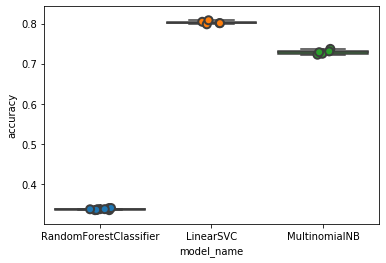

In [233]:
#graph the model's accuracy
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [234]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.802457
MultinomialNB             0.728620
RandomForestClassifier    0.337564
Name: accuracy, dtype: float64

<blockquote>The linear SVC had the highest accuracy.</blockquote>

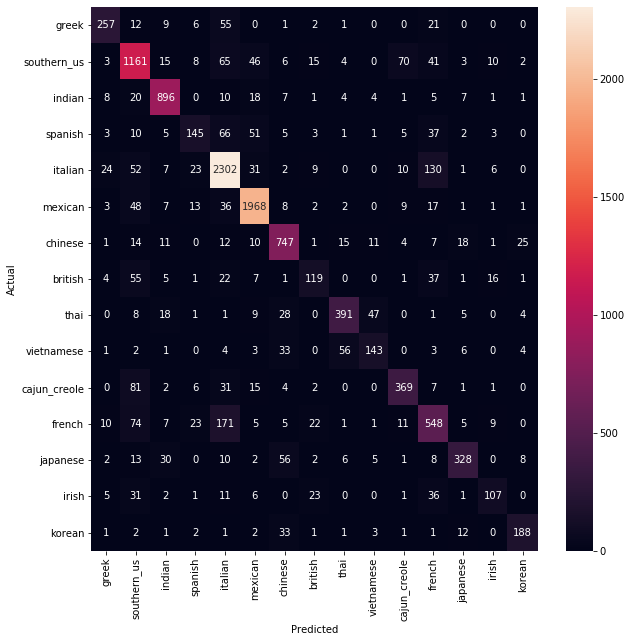

In [236]:
#Selected the most accurate model to investgate it's accuracy
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_clean_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.cuisine.values, yticklabels=category_id_df.cuisine.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<blockquote>Along the center diagonal are the recipes the machine correct determine the cuisine, the incorrect ones are shown in the grid based on their actual category and the category that was predicted.<blockquote>

In [279]:
#display example recipes that were miscategorized
#Italian and French are the cuisine that are most often conflated
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 80:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(train_clean_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['cuisine', 'text']])
            print('')

'cajun_creole' predicted as 'southern_us' : 81 examples.


cuisine                                               text
31584  cajun_creole  vegetable_juice,hot_sauce,prepared_horseradish...
24825  cajun_creole  milk,baking_powder,all-purpose_flour,sugar,uns...
6033   cajun_creole  eggs,active_dry_yeast,buttermilk,dark_brown_su...
2407   cajun_creole  black_pepper,paprika,dill_pickles,vegetable_oi...
18465  cajun_creole  cooked_rice,vegetable_oil,flour,salt,sugar,van...
...             ...                                                ...
35922  cajun_creole  milk_chocolate,chocolate_shavings,all-purpose_...
4343   cajun_creole  baby_lima_beans,cooking_oil,salt,onions,canned...
18241  cajun_creole  chopped_green_bell_pepper,chopped_fresh_thyme,...
22009  cajun_creole  green_bell_pepper,olive_oil,garlic_cloves,grit...
6298   cajun_creole  minced_garlic,salt,dried_minced_onion,crushed_...

[81 rows x 2 columns]


'french' predicted as 'italian' : 171 examples.


cuisine                                               text
36215  french  white_wine,ground_black_pepper,salt,fresh_rose...
31551  french  salt,heavy_cream,semi-sweet_chocolate_morsels,...
21543  french  dijon_mustard,mixed_greens,sherry_vinegar,extr...
759    french  whole_milk,fine_sea_salt,vanilla_sugar,lemon,h...
1977   french  large_egg_whites,salt,potato_starch,unsalted_b...
...       ...                                                ...
2625   french  olive_oil,cracked_black_pepper,tomato_paste,po...
6840   french  baby_arugula,lemon_wedge,anchovy_paste,cherry_...
15183  french  mayonaise,asparagus,worcestershire_sauce,conde...
28055  french  extra-virgin_olive_oil,fresh_basil_leaves,cape...
5769   french  hazelnuts,large_eggs,salt,kahlúa,unsalted_butt...

[171 rows x 2 columns]


'italian' predicted as 'french' : 130 examples.


cuisine                                               text
22782  italian  vanilla_beans,whipping_cream,blackberries,suga...
17028  italian  butter,ham,grated_parmesan_cheese,basil_dried_...
2550   italian  black_pepper,large_eggs,fresh_tarragon,unsalte...
25428  italian        extra-virgin_olive_oil,sea_salt,green_beans
19542  italian  hazelnut_butter,large_eggs,granulated_sugar,bi...
...        ...                                                ...
20182  italian  brown_sugar,balsamic_vinegar,onions,olive_oil,...
22054  italian  coffee_granules,bittersweet_chocolate,sugar,1%...
34647  italian  sea_scallops,freshly_ground_pepper,whole_wheat...
31774  italian  cold_water,unsalted_butter,all-purpose_flour,c...
3257   italian  butter,green_beans,grated_lemon_zest,pepper,ga...

[130 rows x 2 columns]

In [237]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=train_clean_df['cuisine'].unique()))

              precision    recall  f1-score   support

       greek       0.80      0.71      0.75       364
 southern_us       0.73      0.80      0.77      1449
      indian       0.88      0.91      0.90       983
     spanish       0.63      0.43      0.51       337
     italian       0.82      0.89      0.85      2597
     mexican       0.91      0.93      0.92      2116
     chinese       0.80      0.85      0.82       877
     british       0.59      0.44      0.50       270
        thai       0.81      0.76      0.79       513
  vietnamese       0.67      0.56      0.61       256
cajun_creole       0.76      0.71      0.74       519
      french       0.61      0.61      0.61       892
    japanese       0.84      0.70      0.76       471
       irish       0.69      0.48      0.56       224
      korean       0.80      0.76      0.78       249

    accuracy                           0.80     12117
   macro avg       0.76      0.70      0.72     12117
weighted avg       0.79   

<blockquote> The F score is used to measure a test’s accuracy by taking into account precision and recall to do it.</blockquote>